<h1><center> myGP </center></h1>  
<h5><center> by Ben Boyd </center></h5>  

This is a short notebook showing how to create your own Gaussian Process and how to then further extend it into learning two-dimensional surface. 

The first step when formulating a Gaussian process is to decided on your kernel. This essentially works out the covariance between two vectors according to a defined function. For this work we use the squared exponential kernel:

<center>$ k(x,x')  = \sigma_k^2 e^{-(x-x')^2/2l^2} $</center>

Where $l$ and $\sigma_k^2$ represent the length scale and output variacne respectively. These act as hyperparameters that need to be fine tuned. 

You can then use the kernel to model the joint probability of training ouput points $\bf Y$ of size $N$ and testing ouput points $\bf{y_*}$ of size $M$ given corresponding input points $\bf{X}$ and $\bf{x_*}$. 

The model is a multivariate gaussian distribution such that:
\begin{equation}
p(Y ,y_*|X,x_*,\sigma)= \textit{N}\bigg(\begin{bmatrix}\begin{pmatrix}
Y\\
y_*\\
\end{pmatrix};
\begin{pmatrix}
0\\
0\\
\end{pmatrix},
\begin{pmatrix}
k(X,X) + \sigma^2 I_N & k(x_*,X) \\
k(x_*,X) & k(x_*,x_*)+\sigma^2 I_M\\
\end{pmatrix}
\end{bmatrix} \bigg)\end{equation}
where $\sigma$ is the error on each point.

The model can the be used to find the posterior to predict test points $\bf{y_*}$ given the training points $\bf{Y}$ using:

\begin{equation}
p(y_*|Y,X,x_*,\sigma)= \textit{N}\bigg( 
y_*; k(x_*,X)[k(X,X)+\sigma^2 I_N]^{-1}Y,
k(x_*,x_*) + \sigma^2 I_M -k(x_*,X) [k(X,X)+\sigma^2 I_N]^{-1}k(X,x_*)
\bigg) \end{equation}






In [1]:
import numpy as np
from matplotlib import pyplot as plt

def kernel(x1,x2,sig=1,l=1):
    
    return sig**2 * np.exp(-(x1-x2)**2/(2*l**2))


def GP_posterior(x,X_train,Y_train,noise=0.05):
    mu=kernel(x,X_train.T)@ np.linalg.inv(kernel(X_train,X_train.T)+np.eye(X_train.shape[0])*noise**2)@Y_train
    cov=kernel(x,x.T) + noise**2 -kernel(x,X_train.T) @np.linalg.inv(kernel(X_train,X_train.T)+np.eye(X_train.shape[0])*noise**2)@kernel(X_train,x.T)

    return np.random.multivariate_normal(mu[:,0],np.sqrt(cov**2)),mu,np.sqrt(cov**2)


In [2]:
x=np.array([np.linspace(-4,10,100)]).T-5
X_train=np.array([np.linspace(0,5,10)]).T-5
Y_train=np.sin(X_train*2)+np.random.normal(0,0.1,size=X_train.shape)
pred,mu,cov=GP_posterior(x,X_train,Y_train,noise=0.2)



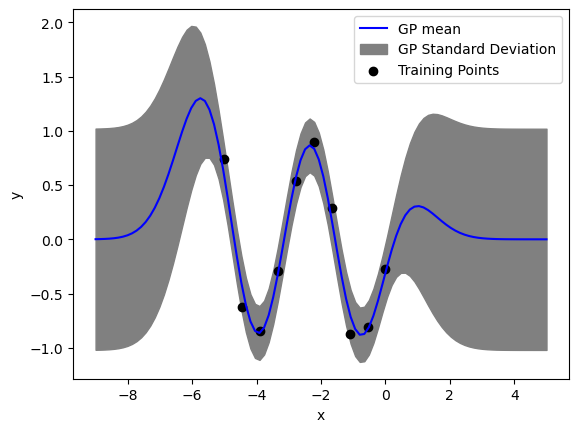

In [3]:
plt.plot(x,mu,color='blue',label='GP mean')
plt.fill_between(x[:,0],mu[:,0]-np.sqrt(np.diag(cov)),mu[:,0]+np.sqrt(np.diag(cov)),color='grey',label='GP Standard Deviation')
plt.scatter(X_train[:,0],Y_train[:,0],color='black',label='Training Points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

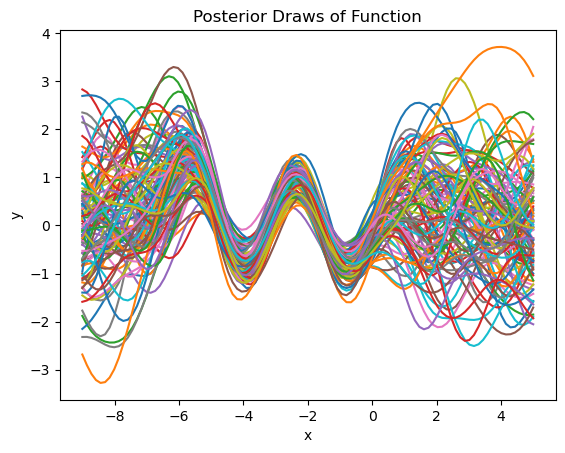

In [4]:
plt.title('Posterior Draws of Function')
for i in range(100):
    pred,mu,cov=GP_posterior(x,X_train,Y_train,noise=0.2)
    plt.plot(x[:,0],pred)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


The same framework can be used to predict the posterior of a two dimensional surface $p(z|x,y)$. All that is needed to do is change the definition of the kernel by multipying two one-dimensional kernels:

<center>$ k_{2D}(x,x',y,y')  = k(x,x')k(y,y')$ </center> 

In [5]:
def kernel_2d(x1,x2,y1,y2,sig=1,l=1):
     
    return kernel(x1,x2)*kernel(y1,y2)


def GP_posterior_2d(x,y,X_train,Y_train,Z_train,noise=0.05,sample=False):    
    mu=kernel_2d(x,X_train.T,y,Y_train.T)@ np.linalg.inv(kernel_2d(X_train,X_train.T,Y_train,Y_train.T)+np.eye(X_train.shape[0])*noise**2)@Z_train
    cov=kernel_2d(x,x.T,y,y.T) + noise**2 -kernel_2d(x,X_train.T,y,Y_train.T) @np.linalg.inv(kernel_2d(X_train,X_train.T,Y_train,Y_train.T)+np.eye(X_train.shape[0])*noise**2)@kernel_2d(X_train,x.T,Y_train,y.T)
    
    if sample:
        return np.random.multivariate_normal(mu[:,0],np.sqrt(cov**2)),mu,np.sqrt(cov**2)
    
    else:
        return mu,cov

In [6]:
#Training set
X_train=np.array([np.random.rand(1000)]).T*10-5
Y_train=np.array([np.random.rand(1000)]).T*10-5
Z_train=np.sin(X_train)+np.cos(Y_train)+np.random.normal(0,0.1,size=X_train.shape)

#Test set
x=np.array([np.random.rand(10000)]).T*10-5
y=np.array([np.random.rand(10000)]).T*10-5

#Held out solution
z=np.sin(x)+np.cos(y)+np.random.normal(0,0.1,size=x.shape)



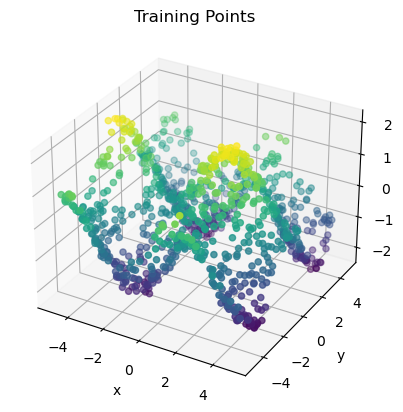

In [7]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_title('Training Points')
ax.scatter(X_train, Y_train, Z_train, c=Z_train)

ax.set_xlabel('x')
ax.set_ylabel('y')


plt.show()

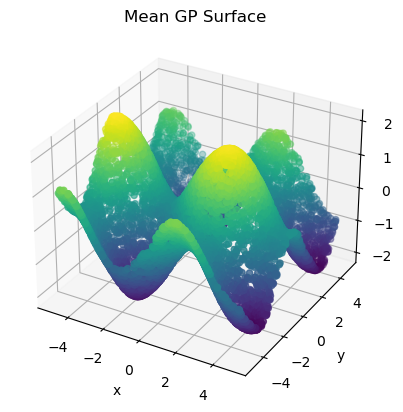

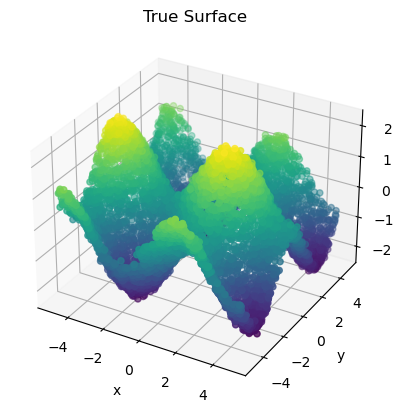

In [8]:
mu,cov=GP_posterior_2d(x,y,X_train,Y_train,Z_train,noise=0.2)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_title('Mean GP Surface')
ax.scatter(x,y,mu, c=mu)

ax.set_xlabel('x')
ax.set_ylabel('y')


plt.show()


fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.set_title('True Surface')

ax.scatter(x,y,z, c=z)

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

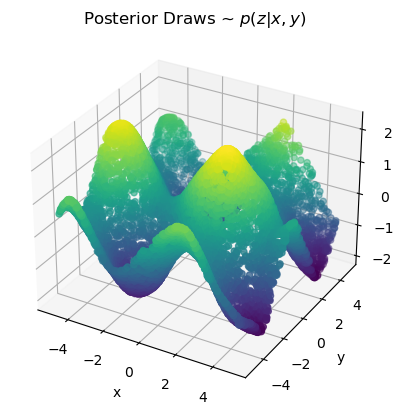

In [9]:

pred,mu,cov=GP_posterior_2d(x,y,X_train,Y_train,Z_train,noise=0.2,sample=True)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title(r'Posterior Draws ~ $p(z|x,y)$')

ax.scatter(x,y,pred, c=pred)

ax.set_xlabel('x')
ax.set_ylabel('y')


plt.show()

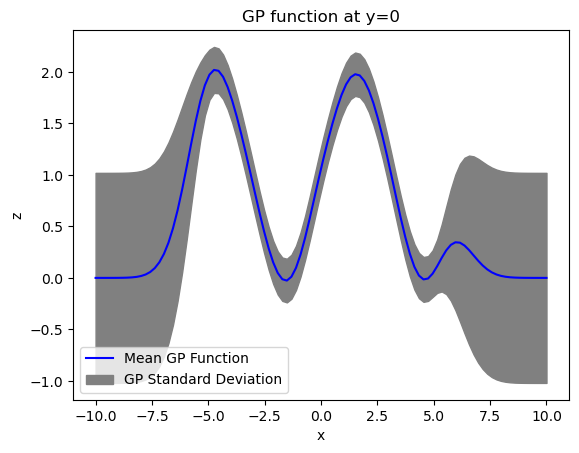

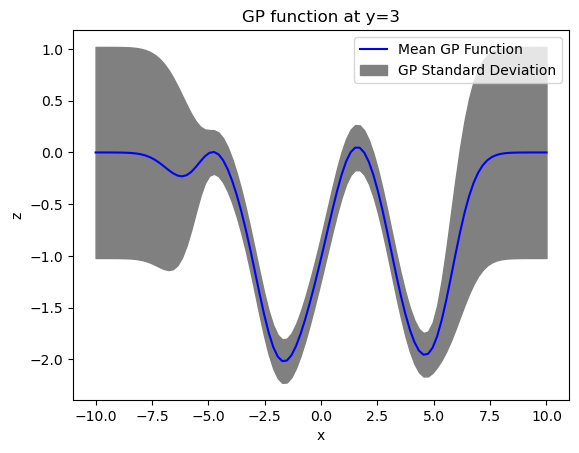

In [10]:
x_slice=np.array([np.linspace(-10,10,100)]).T
y_slice=np.array([np.zeros(100)]).T
mu,cov=GP_posterior_2d(x_slice,y_slice,X_train,Y_train,Z_train,noise=0.2,sample=False)
cov=np.sqrt(cov**2)
plt.plot(x_slice[:,0],mu[:,0],color='blue',label='Mean GP Function')
plt.fill_between(x_slice[:,0],mu[:,0]-np.sqrt(np.diag(cov)),mu[:,0]+np.sqrt(np.diag(cov)),color='grey',label='GP Standard Deviation')
plt.legend()
plt.xlabel('x')
plt.ylabel('z')
plt.title('GP function at y=0')
plt.show()

x_slice=np.array([np.linspace(-10,10,100)]).T
y_slice=np.array([np.zeros(100)]).T+3
mu,cov=GP_posterior_2d(x_slice,y_slice,X_train,Y_train,Z_train,noise=0.2,sample=False)
cov=np.sqrt(cov**2)
plt.plot(x_slice[:,0],mu[:,0],color='blue',label='Mean GP Function')
plt.fill_between(x_slice[:,0],mu[:,0]-np.sqrt(np.diag(cov)),mu[:,0]+np.sqrt(np.diag(cov)),color='grey',label='GP Standard Deviation')
plt.legend()
plt.xlabel('x')
plt.ylabel('z')
plt.title('GP function at y=3')
plt.show()